# <span style="color: black;"><center>Diplomado de Inteligencia Artificial y Aprendizaje Profundo</center></span>

# <span style="color: purple;"><center>Restaurador de Documentos</center></span>

## <span style="color: black;">Presentado por:</span>

## <span style="color: purple;">Andrés Felipe Nieto Grandas</span>

### <span style="color: purple;">Introducción</span>

**<p>En este cuaderno me propongo a ilustrar el proceso de preparacion de datos, modelamiento y entrenamiento de una maquina capaz de restaurar documentos.</p>**

### <span style="color: purple;">Importamos las librerias</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
from pathlib import Path

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

%matplotlib inline

### <span style="color: purple;">Revisamos tipos de datos vamos a manejar</span>

#### <span style="color: black;">Los datos estan en comprimidos en formato .zip</span>

In [2]:
train_dataset = "train"
clean_dataset = "train_cleaned"
test_dataset = "test"

base_path = "denoising-dirty-documents/"

def extract_files(base_path,dataset):
    full = os.path.join(base_path,dataset)
    # Will unzip the files so that you can see them..
    with zipfile.ZipFile(full+".zip","r") as z:
        z.extractall(".")

#### <span style="color: black;">Descomprimimos los archivos en la carpeta data</span>

In [3]:
for dataset in [train_dataset, clean_dataset, test_dataset]:
    extract_files(base_path, dataset)

#### <span style="color: black;">Vamos a guardar los nombres de las imagenes en una lista para poder pintarlos de manera mas simple</span>

In [4]:
for folder in ["test", "train", "train_cleaned"]:
    base_dir = "data/"
    txt_dir = os.path.join(base_dir, folder, "text")
    mv_dir = os.path.join(base_dir, folder)
    !mkdir -p  $txt_dir
    !mv $mv_dir/*.png $txt_dir

mv: no se puede efectuar `stat' sobre 'data/test/*.png': No existe el archivo o el directorio
mv: no se puede efectuar `stat' sobre 'data/train/*.png': No existe el archivo o el directorio
mv: no se puede efectuar `stat' sobre 'data/train_cleaned/*.png': No existe el archivo o el directorio


In [5]:
dir_to_scan = "data/train/text"
data_dir = Path(dir_to_scan)
image_count = len(list(data_dir.glob('*.png')))
image_count

144

### <span style="color: purple;">Procedemos a preparar los datos</span>

#### <span style="color: black;">Tranformación de los datos a escala 255</span>

In [6]:
BATCH_SIZE = 32
IMG_HEIGHT = 420
IMG_WIDTH = 540

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(directory="data/train",
                                                     batch_size=BATCH_SIZE,
                                                     #shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH), 
                                                     color_mode='grayscale',
                                                     class_mode='input')

Found 144 images belonging to 1 classes.


In [9]:
validation_generator = valid_datagen.flow_from_directory(directory=str("data/train_cleaned"),
                                                     batch_size=BATCH_SIZE,
                                                     #shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     color_mode='grayscale',    
                                                     class_mode='input')

Found 144 images belonging to 1 classes.


In [10]:
test_generator = test_datagen.flow_from_directory(directory=str("data/test"),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     color_mode='grayscale',
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='input')

Found 72 images belonging to 1 classes.


### <span style="color: purple;">Creación del modelo a entrenar</span>

In [11]:
def build_encoder():

    input_img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)) 
    
    # Encoding Layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoding Layers 
    x = Conv2DTranspose(filters=32,kernel_size=3,strides=(2, 2),padding="same",activation='relu')(encoded)
    x = Conv2DTranspose(filters=32,kernel_size=3,strides=(2, 2),padding="same",activation='relu')(x)
    decoded = Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="same", activation='sigmoid')(x)
    
    return Model(input_img, decoded)

In [12]:
autoencoder = build_encoder()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mse'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 420, 540, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 210, 270, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 210, 270, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 105, 135, 32)      0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 210, 270, 32)      9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 420, 540, 32)      9248  

In [14]:
history = autoencoder.fit(
      x=train_generator,
      epochs=100,
      validation_data = validation_generator,
      callbacks=[reduce_lr])

Epoch 1/100
5/5 [==============================] - 77s 15s/step - loss: 0.0757 - mse: 0.0757 - val_loss: 0.1031 - val_mse: 0.1031 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 50s 10s/step - loss: 0.0490 - mse: 0.0490 - val_loss: 0.0726 - val_mse: 0.0726 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 53s 11s/step - loss: 0.0543 - mse: 0.0543 - val_loss: 0.0732 - val_mse: 0.0732 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 79s 16s/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0892 - val_mse: 0.0892 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - 76s 15s/step - loss: 0.0465 - mse: 0.0465 - val_loss: 0.0893 - val_mse: 0.0893 - lr: 0.0010
Epoch 6/100
5/5 [==============================] - 47s 9s/step - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0760 - val_mse: 0.0760 - lr: 0.0010
Epoch 7/100
5/5 [==============================] - 52s 10s/step - loss: 0.0436 - mse: 0.0436 - val_loss: 0.0736 - val_mse: 0.0736 - lr: 0.0010


In [16]:
autoencoder.save('restauradormodel.h5')

In [17]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

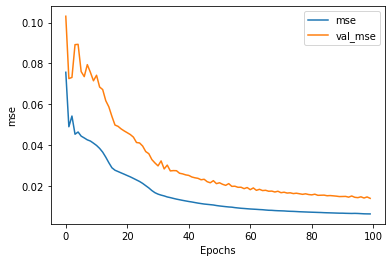

In [18]:
plot_graphs(history, 'mse')

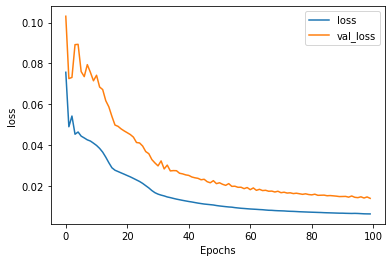

In [19]:
plot_graphs(history, 'loss')

In [20]:
preds = autoencoder.predict(test_generator)
#preds = np.squeeze(preds)

In [21]:
def plot_preds(test, preds,n=1):
    plt.figure(figsize=(30, 20))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        test = test *  255.0
        plt.imshow(test.reshape((420,540)),cmap='gray')
        #plt.imshow(np.squeeze(test), cmap='gray')

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        preds = preds* 255.0
        plt.imshow(preds.reshape((420,540)), cmap='gray')
        #plt.imshow(np.squeeze(preds), cmap='gray')
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [22]:
test_generator[0][0][0].shape

(420, 540, 1)

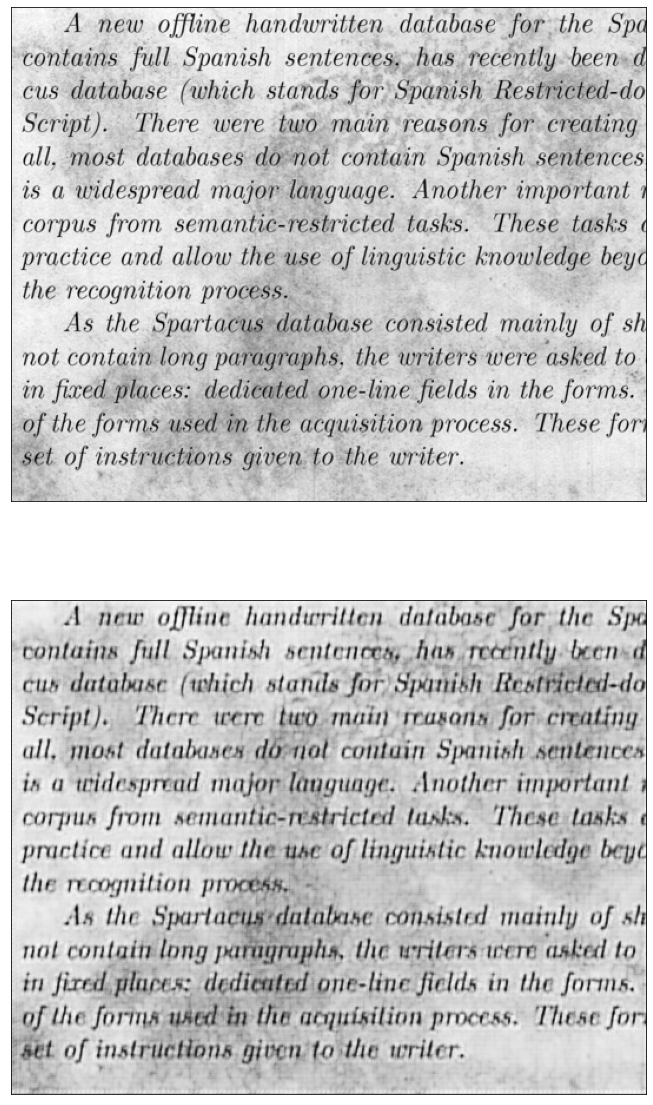

In [26]:
plot_preds(test_generator[0][0][20], preds[20],1)